# setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
# os.chdir('/Users/martinmarek/Google Drive/UCL/STAT0035/bnn-regression')
os.chdir('/content/drive/MyDrive/UCL/STAT0035/bnn-regression')

In [4]:
%%capture
!pip install dm-haiku
!pip install numpyro

# imports

In [5]:
# system imports
import numpy as onp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
import pandas as pd
from numpyro.infer import MCMC, NUTS

# relative imports
from core import models, distributions, utils, metrics
from core.hmc import hmc_sampler
from core.nuts import nuts
from core.rwmh import rwmh_sampler
from core.sgd import train_sgd

In [6]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# dataset

In [7]:
def load_naval_dataset(ds_path, key, train_fraction=0.9):
    """
    load UCI naval regression dataset
    - x.shape: [11934, 14]
    - y.shape: [11934]
    - ported from: 
      - https://github.com/google-research/google-research/blob/b24af2d59ea3d82799a1a773c896a1c4911b148f/bnn_hmc/utils/data_utils.py#L174
      - https://github.com/wjmaddox/drbayes/blob/0efbd081b7ccecdb2fea8e949ad81065c26faa54/experiments/uci_exps/bayesian_benchmarks/data.py#L157
    """
    # read raw dataset
    data = pd.read_fwf(ds_path, header=None).values
    data = data.astype(onp.float32)

    # only consider the first output
    x = data[:, :-2]
    y = data[:, -2]#.reshape(-1, 1)

    # remove columns 8 and 11, they have have std=0
    x = onp.delete(x, [8, 11], axis=1)

    # shuffle dataset
    indices = jax.random.permutation(key, len(x))
    indices = onp.asarray(indices)
    x, y = x[indices], y[indices]

    # train / test split
    n_train = int(train_fraction * len(x))
    x_train, y_train = x[:n_train], y[:n_train]
    x_test, y_test = x[n_train:], y[n_train:]

    def normalize_with_stats(arr, arr_mean=None, arr_std=None):
        return (arr - arr_mean) / arr_std

    def normalize(arr):
        eps = 1e-6
        arr_mean = arr.mean(axis=0, keepdims=True)
        arr_std = arr.std(axis=0, keepdims=True) + eps
        return normalize_with_stats(arr, arr_mean, arr_std), arr_mean, arr_std

    # normalize
    x_train, x_mean, x_std = normalize(x_train)
    y_train, y_mean, y_std = normalize(y_train)
    x_test = normalize_with_stats(x_test, x_mean, x_std)
    y_test = normalize_with_stats(y_test, y_mean, y_std)

    return (x_train, y_train), (x_test, y_test)

In [8]:
ds_path = 'naval_dataset/data.txt'
key = jax.random.PRNGKey(0)
(x_train, y_train), (x_test, y_test) = load_naval_dataset(ds_path, key)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(10740, 14) (10740,) (1194, 14) (1194,)


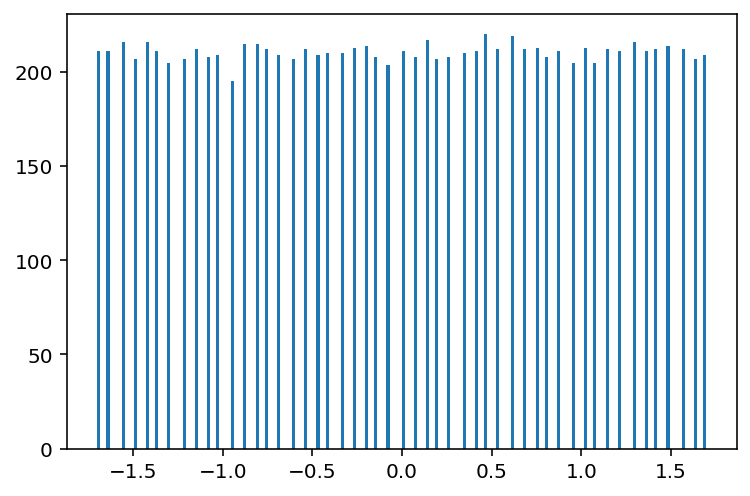

In [9]:
plt.hist(y_train, bins=200)
plt.show()

# model

In [10]:
# define model
# - when using a large NN with a small dataset, the prior must be very flat so that it doesn't dominate the likelihood
layer_dims = 1*[50]
init_sd = 0.1
prior_sd = 1
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
params_init = jax.tree_map(lambda x: init_sd*x, params_init)
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior(log_likelihood_fn, log_prior_fn)

In [11]:
# test model
print('Num. params: ', len(utils.ravel_pytree_(params_init)))
print('Params: ', jax.tree_map(lambda x: x.shape, params_init))

# TEST: prior, likelihood, posterior
print('PDF test: ', log_prior_fn(params_init), log_likelihood_fn(params_init), log_posterior_fn(params_init))

Num. params:  852
Params:  {'linear': {'b': (50,), 'w': (14, 50)}, 'linear_1': {'b': (2,), 'w': (50, 2)}}
PDF test:  -787.09735 -16665.818 -17452.916


# training

In [12]:
# create multiple chains using each method to allow cmputing r_hat
n_chains = 3

# number of samples to keep from each chain
n_samples = 100

# stdev for sampling the initial params in each chain
init_sd = 0.1

## SGD

In [13]:
%%time
key = jax.random.PRNGKey(0)
sgd_n_epochs = 10_000
sgd_ll_start = 1e-4
sgd_ll_stop = 1e-8

chains_sgd = []
for i in range(n_chains):
    print(f'Running chain {i}...')
    key, init_key = jax.random.split(key, 2)
    params_start = utils.normal_like_tree(params_init, init_key)
    params_start = jax.tree_map(lambda x: init_sd*x, params_start)
    params, loss_history = train_sgd(params_start, log_likelihood_fn, sgd_n_epochs, sgd_ll_start, sgd_ll_stop)
    chains_sgd += [[params]]

Running chain 0...
Running chain 1...
Running chain 2...
CPU times: user 4min 21s, sys: 5.93 s, total: 4min 27s
Wall time: 3min 27s


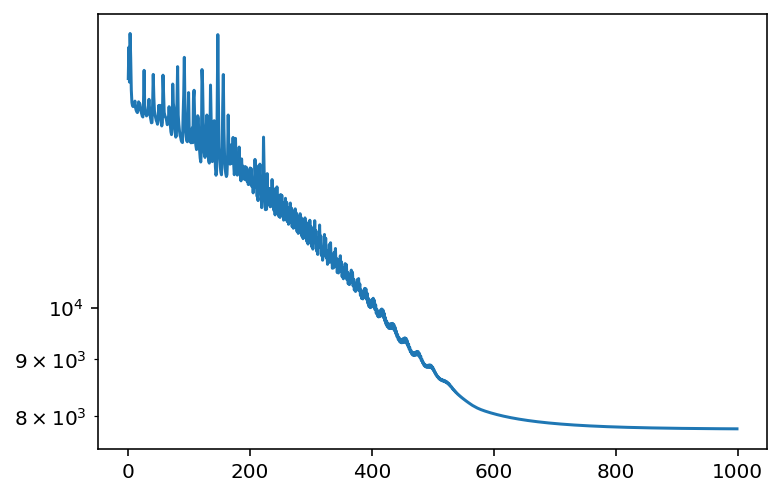

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_history)
plt.yscale('log')
plt.show()

## RWMH

In [ ]:
%%time
key = jax.random.PRNGKey(0)
n_blind_steps = 100
step_size = 1e-3
chains_rwmh = []
for i in range(n_chains):
    print(f'Running chain {i}...')
    key, init_key, mcmc_key = jax.random.split(key, 3)
    params_start = utils.normal_like_tree(params_init, init_key)
    params_start = jax.tree_map(lambda x: init_sd*x, params_start)
    chain = rwmh_sampler(params_start, log_posterior_fn, mcmc_key, n_samples, n_blind_steps, step_size)
    chains_rwmh += [chain]

Running chain 0...
Avg. accept. prob.: 66.60%
Running chain 1...
Avg. accept. prob.: 63.36%
Running chain 2...
Avg. accept. prob.: 63.81%
CPU times: user 29.7 s, sys: 7.21 s, total: 36.9 s
Wall time: 18.9 s


## HMC

In [ ]:
%%time
step_size = 1e-4
n_leapfrog_steps = 10_000
key = jax.random.PRNGKey(0)
chains_hmc = []
for i in range(n_chains):
    key, init_key, mcmc_key = jax.random.split(key, 3)
    params_start = utils.normal_like_tree(params_init, init_key)
    params_start = jax.tree_map(lambda x: init_sd*x, params_start)
    chain = hmc_sampler(params_start, log_posterior_fn, n_samples, n_leapfrog_steps, step_size, key)
    chains_hmc += [chain]

Avg. accept. prob.: 98.78%
Avg. accept. prob.: 98.78%
Avg. accept. prob.: 99.20%
CPU times: user 40 s, sys: 185 ms, total: 40.1 s
Wall time: 40.3 s


## NUTS

In [ ]:
%%time
# actually, NUTS never decets a U-turn, it reaches the max. num. of steps
# - given this reality, HMC makes more sense
n_steps = 10
step_size = 1e-4
max_leapfrog_steps = 2 ** 14
print(f'{max_leapfrog_steps=}')
key = jax.random.PRNGKey(0)
chain = nuts(params_init, log_posterior_fn, step_size, key, n_steps, max_leapfrog_steps)

max_leapfrog_steps=16384
16384.00 steps, 100.00% valid, 99.98% acceptance.
Termination: max_steps=10, u-turn=0, max_error=0.
CPU times: user 6.22 s, sys: 81.2 ms, total: 6.3 s
Wall time: 6.32 s


## combined training

In [ ]:
%%time
# TODO: sometimes, the acceptance rate is very small... why?
n_outer_steps = 10
n_inner_steps = 10
step_size = 1e-4
n_leapfrog_steps = 10_000
key = jax.random.PRNGKey(0)
chains_mixed = []
for i in range(n_chains):
    chain_outer = []
    for j in range(n_outer_steps):
        key, init_key, mcmc_key = jax.random.split(key, 3)
        params_start = utils.normal_like_tree(params_init, init_key)
        params_start = jax.tree_map(lambda x: init_sd*x, params_start)
        params_sgd, log_prob_sgd = train_sgd(params_start, log_likelihood_fn)
        chain_inner = hmc_sampler(params_sgd, log_posterior_fn, n_inner_steps, n_leapfrog_steps, step_size, mcmc_key)
        chain_outer += chain_inner
    chains_mixed += [chain_outer]

Avg. accept. prob.: 99.13%
Avg. accept. prob.: 97.86%
Avg. accept. prob.: 98.43%
Avg. accept. prob.: 97.88%
Avg. accept. prob.: 97.69%
Avg. accept. prob.: 98.97%
Avg. accept. prob.: 88.20%
Avg. accept. prob.: 98.67%
Avg. accept. prob.: 98.71%
Avg. accept. prob.: 75.58%
Avg. accept. prob.: 96.70%
Avg. accept. prob.: 97.73%
Avg. accept. prob.: 84.15%
Avg. accept. prob.: 97.93%
Avg. accept. prob.: 90.70%
Avg. accept. prob.: 78.14%
Avg. accept. prob.: 98.79%
Avg. accept. prob.: 98.95%
Avg. accept. prob.: 98.89%
Avg. accept. prob.: 98.85%
Avg. accept. prob.: 99.59%
Avg. accept. prob.: 97.65%
Avg. accept. prob.: 98.25%
Avg. accept. prob.: 98.55%
Avg. accept. prob.: 97.68%
Avg. accept. prob.: 99.24%
Avg. accept. prob.: 98.73%
Avg. accept. prob.: 99.11%
Avg. accept. prob.: 98.90%
Avg. accept. prob.: 86.02%
CPU times: user 2min 17s, sys: 1.41 s, total: 2min 18s
Wall time: 2min 19s


## numpyro

In [ ]:
%%time
potential_fn = lambda x: -log_posterior_fn(x)
nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=n_samples)
chains_numpyro = []
for i in range(n_chains):
    key, init_key, mcmc_key = jax.random.split(key, 3)
    params_start = utils.normal_like_tree(params_init, init_key)
    params_start = jax.tree_map(lambda x: init_sd*x, params_start)
    mcmc.run(mcmc_key, init_params=params_start)
    chain = mcmc.get_samples()
    chains_numpyro += [chain]
    # TODO: numpyro seems to return just the last node, not the full history
    print(len(chain))

sample: 100%|█| 200/200 [00:04<00:00, 41.91it/s, 1023 steps of size 2.06e-03. 


4


sample: 100%|█| 200/200 [00:01<00:00, 100.91it/s, 1023 steps of size 2.68e-03.


4


sample: 100%|█| 200/200 [00:01<00:00, 101.05it/s, 1023 steps of size 3.18e-03.

4
CPU times: user 9.53 s, sys: 156 ms, total: 9.68 s
Wall time: 9.69 s


In [ ]:
len(chains_numpyro[0])

4

In [ ]:
len(chains_rwmh[0])

100

## create chains dict

In [ ]:
chains_dict = {
    'sgd': chains_sgd,
    'rwmh': chains_rwmh,
    'hmc': chains_hmc,
    'mixed': chains_mixed,
    # 'numpyro': chains_numpyro,
}

# predictions

In [ ]:
def chains_to_arr(chains):
    # maps a pytree chain to an nd array
    return jnp.array([[utils.ravel_pytree_(node) for node in chain] for chain in chains])

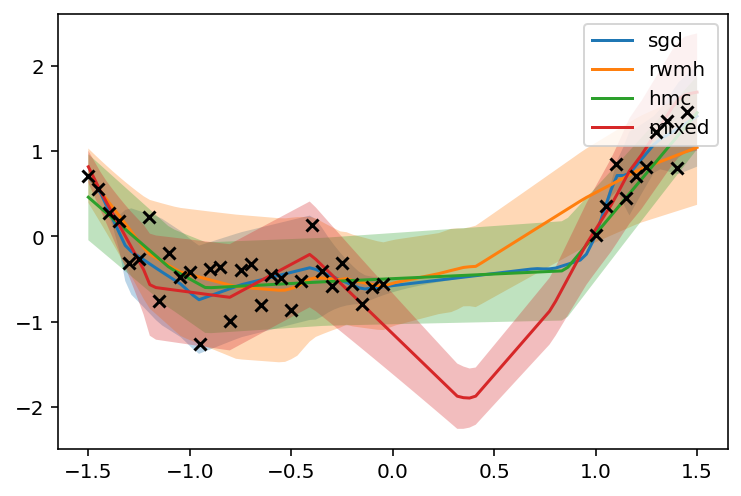

In [ ]:
fig, ax = plt.subplots()

# plot training data
ax.scatter(x_train[:, 0], y_train, marker='x', c='black', zorder=10)

# plot predictions
x_full = jnp.linspace(-1.5, 1.5, 100)[:, None]
for i, (name, chains) in enumerate(chains_dict.items()):
    y_hat = predict_fn(x_full, chains[-1][-1])
    ax.fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3)
    ax.plot(x_full[:, 0], y_hat[:, 0], label=name)

ax.legend(loc='upper right')
plt.show()

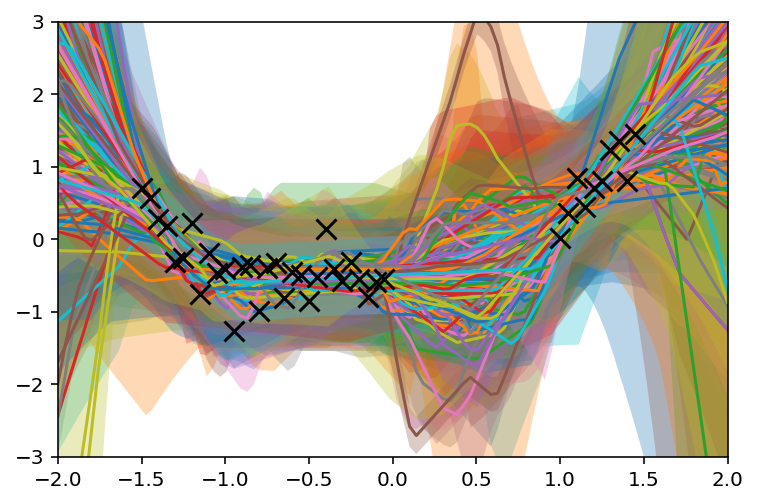

In [ ]:
fig, ax = plt.subplots()

# plot predictions
chain = sum(chains_dict['hmc'], [])
x_full = jnp.linspace(-2, 2, 100)[:, None]
for i, params in enumerate(chain):
    y_hat = predict_fn(x_full, params)
    ax.fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3)
    ax.plot(x_full[:, 0], y_hat[:, 0], label=i)

# plot training data
ax.scatter(x_train[:, 0], y_train, marker='x', c='black', s=100, zorder=10)
ax.set_xlim([-2, 2])
ax.set_ylim([-3, 3])

# ax.legend()
plt.show()

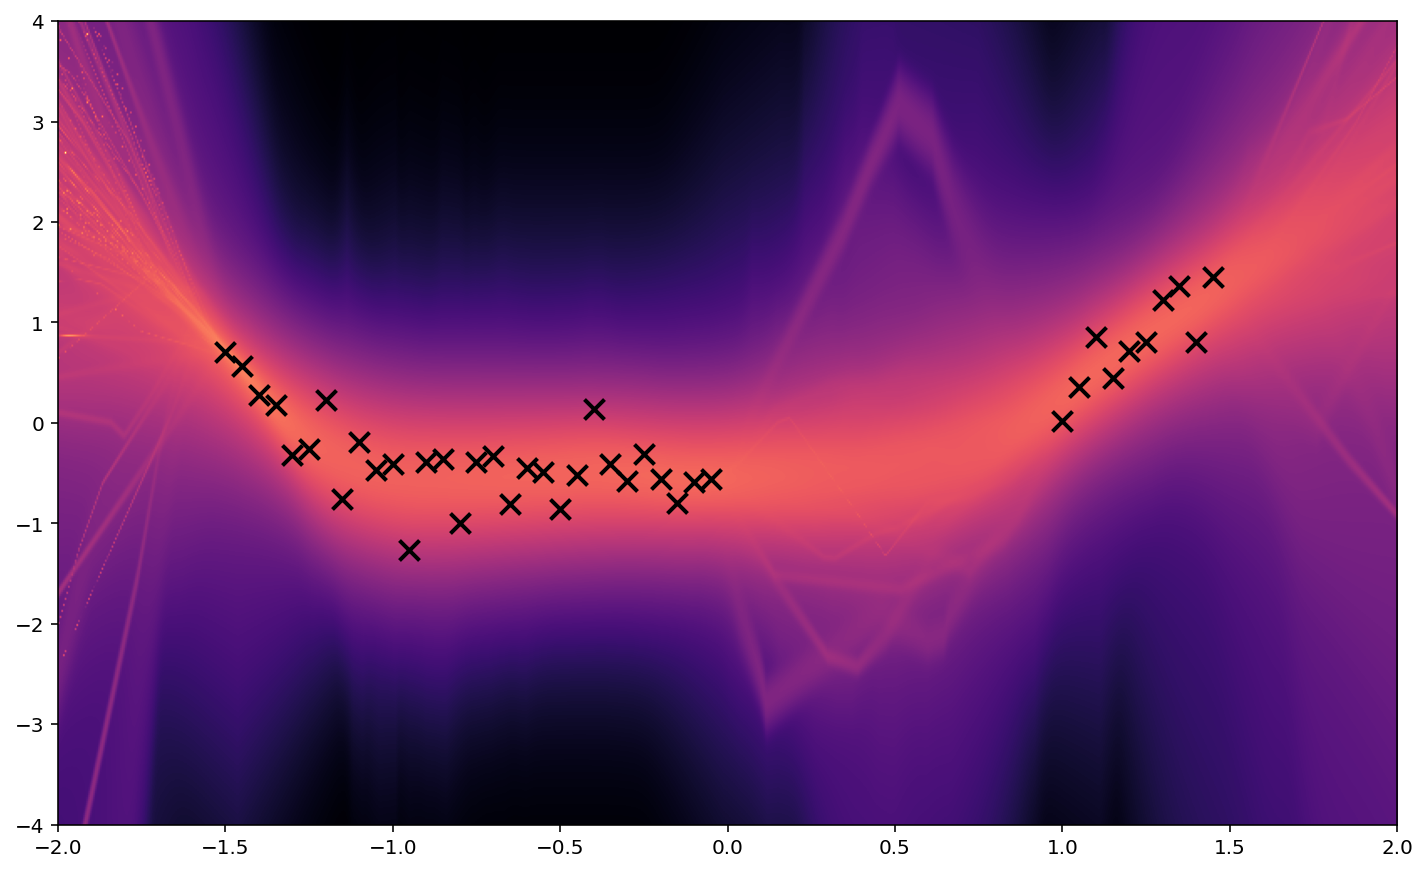

In [ ]:
# load chain
chains = chains_dict['hmc']
chains = chains_to_arr(chains)
M, N, D = chains.shape
chains = chains.reshape([M*N, D])

# create grid to evaluate posterior predictive density
nx, ny = 800, 400
x_full = jnp.linspace(-2, 2, nx)
y_full = jnp.linspace(-4, 4, ny)
# z_full = jnp.zeros([nx, ny, len(params_hmc)])

# create unravel function
params_tree = chains_dict['hmc'][0][-1]
unravel_fn = ravel_pytree(params_tree)[1]

def get_posterior_density(params):
    params = unravel_fn(params)
    y_hat = predict_fn(x_full[:, None], params)
    mean, std = y_hat[:, 0], y_hat[:, 1]
    log_prob = distributions.gaussian_log_pdf(y_full[None, :], mean[:, None], std[:, None])
    log_prob = jnp.nan_to_num(log_prob)
    return log_prob
    # z_full = z_full.at[:, :, i].set(log_prob)
    
density_fn_vmap = jax.vmap(get_posterior_density, 0)
z_full = density_fn_vmap(chains)
    
# average over posterior samples
# - p(y) = sum (p(y|theta_i) * p(theta_i)) = (sum p(y|theta_i)) / n
# - p(y) = (sum exp logp(y|theta_i)) / n
# - logp(y) = log((sum exp logp(y|theta_i)) / n)
# - logp(y) = (log-sum-exp logp(y|theta_i)) - log(n)
log_z_full = jax.scipy.special.logsumexp(z_full, 0) - jnp.log(len(chain))
z_full = jnp.exp(log_z_full)

# density plot
fig, ax = plt.subplots(figsize=[12, 8])
extent = [x_full[0], x_full[-1], y_full[0], y_full[-1]]
ax.imshow(z_full.T**(1/8), origin='lower', cmap='magma', extent=extent, aspect=0.3, label='predicted')
# ax.plot(x_true[:, 0], y_true, label='true', lw=4, c='green')
ax.scatter(x_train[:, 0], y_train, marker='x', color='black', s=100, linewidth=2, label='observed')
# ax.legend()
plt.show()

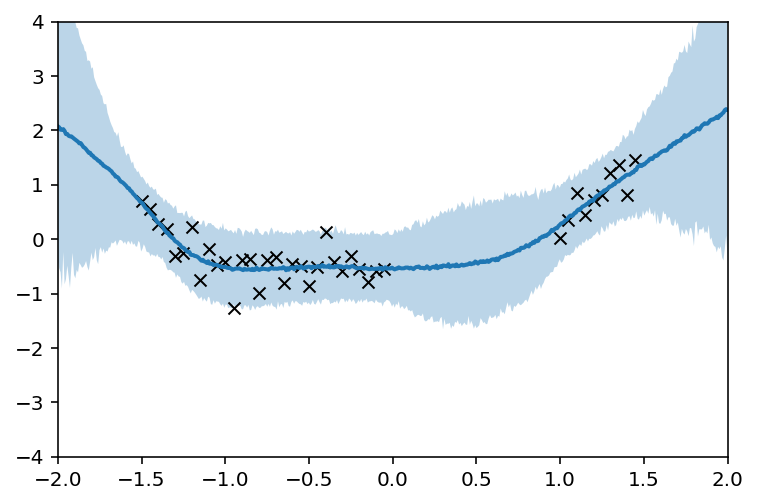

In [ ]:
chain = sum(chains_dict['hmc'], [])
key = jax.random.PRNGKey(0)
alpha = 0.05
n_steps = len(chain)
nx = 500
x_full = jnp.linspace(-2, 2, nx)
n_samples = 1_000
n_samples_per_step = n_samples // len(chain)

samples = jnp.zeros([nx, len(chain), n_samples_per_step])
for i, params in enumerate(chain):
    key, _ = jax.random.split(key)
    y_hat = predict_fn(x_full[:, None], params)
    mean = y_hat[:, 0]
    std = y_hat[:, 1]
    current_samples = mean[:, None] + std[:, None] * jax.random.normal(key, [nx, n_samples_per_step])
    samples = samples.at[:, i, :].set(current_samples)

# flatten sampled predictions across posterior samples
samples = samples.reshape([nx, -1])

# get posterior predictive quntiles
quantiles = jnp.quantile(samples, jnp.array([alpha/2, 0.5, 1-alpha/2]), axis=1)
    
# CI plot
fig, ax = plt.subplots()
ax.fill_between(x_full, quantiles[0, :], quantiles[2, :], alpha=0.3)
ax.plot(x_full, quantiles[1, :], label='predicted', lw=2)
# ax.plot(x_true[:, 0], y_true, label='true', c='red')
ax.scatter(x_train[:, 0], y_train, marker='x', color='black', linewidth=1, label='observed')
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
# ax.legend()
plt.show()

# diagnostics

## history of a single parameter

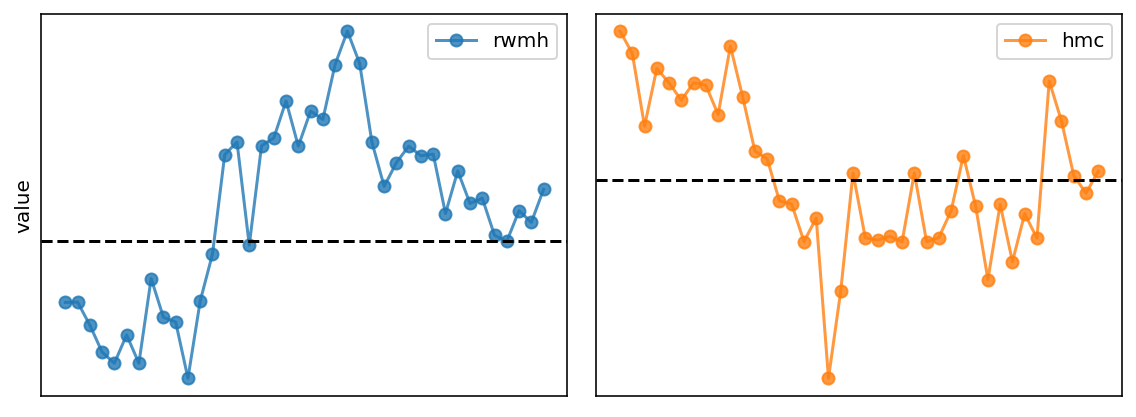

In [ ]:
chain_idx = 0
param_idx = 0
n_points = 40
fig, axs = plt.subplots(1, 2, figsize=[8, 3])
axs = axs.flatten()
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_to_arr(chains_dict[name])
    param = chains[chain_idx, :, param_idx]
    line, = axs[i].plot(param[:n_points].tolist(), 'o-', alpha=0.8, label=name, color=f'C{i}')
    axs[i].axhline(y=chains[:, :, param_idx].mean(), linestyle="--", color='black')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].legend()
    if i in [2, 3]: axs[i].set_xlabel('step')
    if i in [0, 2]: axs[i].set_ylabel('value')
plt.tight_layout()
# plt.savefig('plots/mh_parameter_history.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## autocorrelation

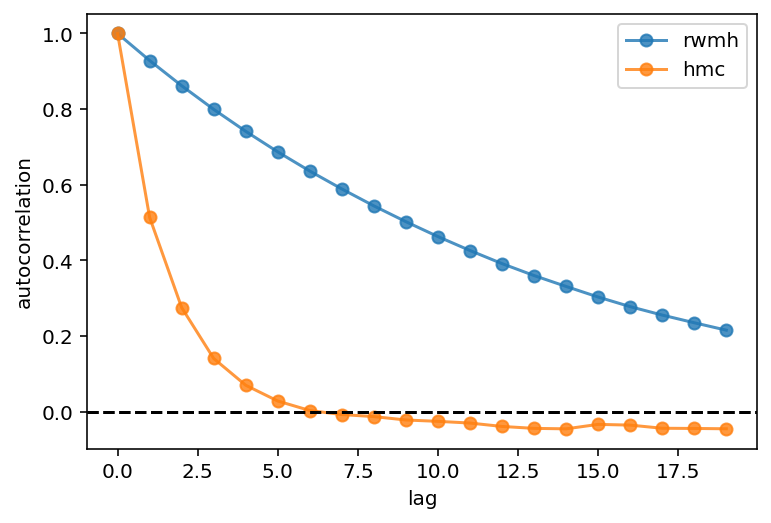

In [ ]:
fig, ax = plt.subplots()

# autocorrelation
f = lambda x: x
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_to_arr(chains_dict[name])
    r = metrics.autocorr(chains, f)
    ax.plot(r.tolist(), 'o-', alpha=0.8, label=name)
    ax.axhline(y=0, color='black', linestyle="--")
ax.legend()
ax.set_xlabel('lag')
ax.set_ylabel('autocorrelation')

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## $\hat{R}$

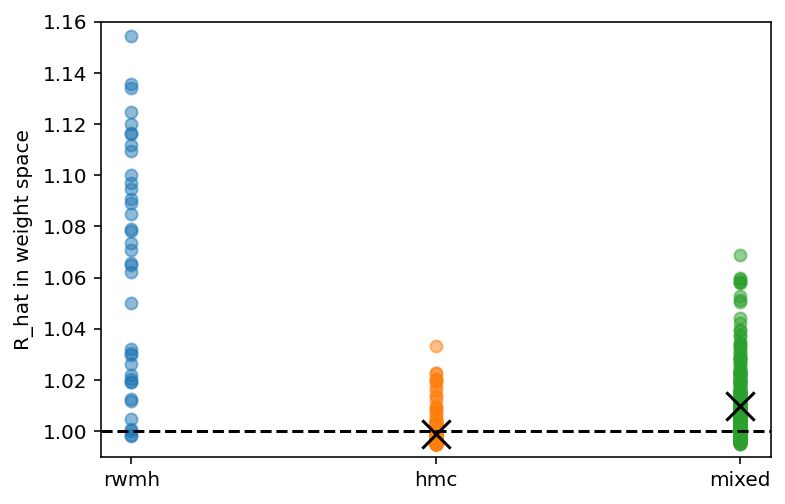

In [ ]:
fig, ax = plt.subplots()

# R_hat
f = lambda x: x
chains_to_show = ['rwmh', 'hmc', 'mixed']
for i, name in enumerate(chains_to_show):
    chains = chains_to_arr(chains_dict[name])
    r = metrics.r_hat(chains, f)
    ax.scatter([i]*len(r), r.tolist(), alpha=0.5)
    ax.scatter(i, r.mean(), color='black', marker='x', s=200, zorder=2)
ax.set_xticks(range(len(chains_to_show)), chains_to_show)
ax.set_ylabel('R_hat in weight space')
ax.axhline(y=1, color='black', linestyle="--")

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
# ax.set_yscale('log')
ax.set_ylim([0.99, 1.16])
plt.show()

## Likelihood of test data

In [ ]:
# create unravel function
params_tree = chains_dict['hmc'][0][-1]
unravel_fn = ravel_pytree(params_tree)[1]

# function like 'predict_fn' but takes in an array an unravels it
def predict_from_array(x, params_flat):
    params_tree = unravel_fn(params_flat)
    y_hat = predict_fn(x, params_tree)
    return y_hat


def chain_to_loglike(chain):
    # compute y_hat for each node in the chain
    predict_vmap = jax.vmap(predict_from_array, [None, 0])
    y_hat = predict_vmap(x_test, chain)
    mean, std = y_hat[:, :, 0], y_hat[:, :, 1]

    # compute likelihood for each node in the chain
    log_likelihood = distributions.gaussian_log_pdf(y_test[None, :], mean, std)

    # average the likelihood across nodes
    log_likelihood = jax.scipy.special.logsumexp(log_likelihood, 0) - jnp.log(len(chain))

    # get total likelihood of all data points
    log_likelihood = log_likelihood.sum()
    return log_likelihood

for i, (name, chains) in enumerate(chains_dict.items()):
    chains = chains_to_arr(chains)
    
    # compute likelihood for each chain
    loss_fn_vmap = jax.vmap(chain_to_loglike, 0)
    loss = loss_fn_vmap(chains)
    
    # ll = chain_to_loglike(chains)
    print(f'{name}: {loss.mean():.3f} ± {loss.std():.4f}')

sgd: -1464072192.000 ± 2069754880.0000
rwmh: -165.434 ± 4.4139
hmc: -173.557 ± 7.7486
mixed: -195.277 ± 29.0562


## Distribution of parameters

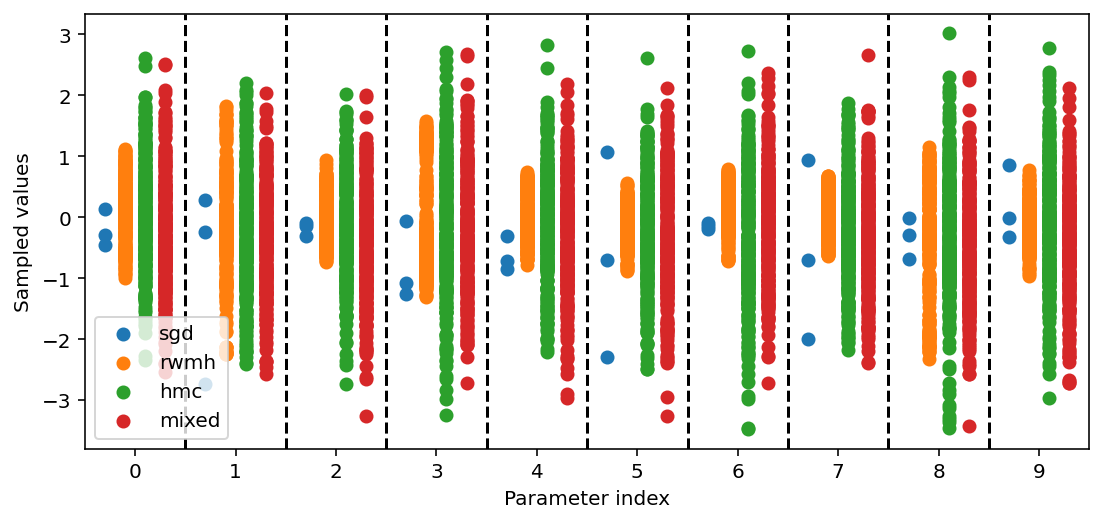

In [ ]:
fig, ax = plt.subplots(figsize=[9, 4])
d = 10 # num. of params to plot
chains_to_show = ['sgd', 'rwmh', 'hmc', 'mixed']
for i, name in enumerate(chains_to_show):
    chains = chains_to_arr(chains_dict[name])
    M, N, D = chains.shape
    y_ = chains.reshape([M*N, D])[:, :d]
    x_ = jnp.zeros([len(y_), 1]) + jnp.arange(d)[None] + (0.2*i - 0.3)
    ax.scatter(x_, y_, c=f'C{i}', alpha=1, label=name)

for i in range(d-1):
    ax.axvline(x=i+0.5, linestyle="--", color='black')

ax.set_xlim([-0.5, d-0.5])
ax.set_xticks(range(10), range(10))
ax.set_xlabel('Parameter index')
ax.set_ylabel('Sampled values')
ax.legend(loc='lower left')
# plt.savefig('plots/parameter_distribution.pdf', bbox_inches='tight', pad_inches=0)
plt.show()